# Welcome to the TELL Quickstarter! 

### **`tell` is an open-source Python package for predicting future electricty load in the United States.**

## A little about `tell`

The Total ELectricity Load (TELL) model predicts the short- and long-term evoluation of hourly electricity demand in response to future climate and population changes. The purpose of `tell` is to generate end-of-century hourly profiles of electricity demand across the entire United States (U.S.) at a spatial resolution adequate for input to a unit commitment/economic dispatch (UC/ED) model while also maintaining consistency with the long-term growth and evolution of annual state-level electricity demand projected by an economically driven human-Earth system model. `tell` takes as input future projections of hourly time-series of meteorology and uses the temporal variations in weather to predict hourly profiles of total electricity demand for every county in the lower 48 states. The core predicitons in `tell` are based on a series of multilayer perceptron (MLP) models for individual Balancing Authorities (BAs). Those MLP models are trained on historical observations of weather and electricity demand. Hourly predictions from `tell` are scaled to match the annual state-level total electricity loads predicted by the U.S. version of the Global Change Analysis Model (GCAM-USA). GCAM-USA captures the long-term co-evolution of the human-Earth system. Using this unique approach allows `tell` to reflect both changes in the shape of the load profile due to variations in weather and the long-term evolution of energy demand due to changes in population, technology, and economics. `tell` is unique from other probabilistic load forecasting models in that it features an explicit spatial component that allows us to relate predicted loads to where they would occur spatially within a grid operations model. The output of `tell` is a series of hourly predictions for future electricity demand at the county, state, and BA scale that are quantitatively and conceptually consistent with one another.

## Lets get started! 

In this quickstarter we will walk through a series of steps for exploring `tell`, starting with importing the package and ending with visualizing the output. This quickstarter is based on a subset of forcing data for `tell`. This allows the user to walk through the entire `tell` package in a matter of minutes. More information about how the model works and how it can be fully applied are available on the [Read the Docs](https://immm-sfa.github.io/tell/index.html) site for `tell`.

## 1. Install `tell`

`tell` is available via GitHub repository by using the pip install functionality below.

In [ ]:
pip install git+https://github.com/IMMM-SFA/tell.git

In [2]:
# Start by importing the TELL package and information about your operating system:
import os 
import tell


## 2. Install the package of raw data underpinning TELL

`tell` is based on open-source publicly accessible data. For convienence, we've packaged all of the core data underpinning `tell` into a [Zenodo data package](https://zenodo.org/record/5714756#.YhkTjxPMJTY). In order to run this notebook, first set the local directory where you would like to store the package data and the run the 'install_package_data' function below. Note that the raw data package will require ~1.6 GB of storage and can take several minutes to download.

In [3]:
# Identify the current working directory and the "tell_data" directory where the data will be stored:
current_dir =  os.path.join(os.path.dirname(os.getcwd()))
tell_data_dir = os.path.join(current_dir, r'tell_data')

# If the "tell_data" subdirectory doesn't exist then create it:
if not os.path.exists(tell_data_dir):
   os.makedirs(tell_data_dir)


In [ ]:
# Download the TELL raw data package from Zenodo:
tell.install_tell_raw_data(data_dir = tell_data_dir)


## 3. Pre-process the data needed for TELL

In the next few code blocks we will load and process the necessary data for `tell`. The raw data (i.e., historical loads, population, meteorology, etc.) is in a variety of different formats determined by their originating organization (e.g., the Energy Information Agency). This series of processing steps cleans the raw data and converts it into a set of simplified .csv files which can be combined together and used as input to the MLP model training steps. Follow the sequence below to pre-process the `tell` input data. If you have already finished this step you can proceed to section 4.

### 3.1. Spatially mapping Balancing Authorities (BAs) to counties

The code block underpins the spatial component of `tell`. The function 'map_ba_service_territory' uses information about Balancing Authorities (BAs) from the [EIA-861](https://www.eia.gov/electricity/data/eia861/) dataset to spatially map BAs to U.S. counties. This allows us to assign loads predicted for individual BAs in `tell` to where they would occur with respect to each other spatially. More information about how BAs are mapped is available on the [Read the Docs](https://immm-sfa.github.io/tell/index.html) site for `tell`.

In [ ]:
# Execute the mapping function for all years from 2015 to 2019:
tell.map_ba_service_territory(start_year = 2015,
                              end_year = 2019,
                              data_input_dir = tell_data_dir)


In [ ]:
# See the output of the mapping step by plotting the service territory for a given BA (e.g., PJM, CISO, ERCO, etc.) in a given year:
tell.plot_ba_service_territory(ba_to_plot = 'PJM',
                               year_to_plot = '2019',
                               data_input_dir = tell_data_dir)


### 3.2. Process the EIA-930 historical hourly demand dataset

Here we convert the raw EIA-930 hourly electricity demand data for BAs from Excel files to .csv files. The function 'process_eia_930' also subsets the EIA-930 dataset to only include the desired variables. Note that this step can take a few minutes even when using parallel processing streams.

In [ ]:
# Execute the function to pre-proceess the raw EIA-930 data using parallel processing streams:
tell.process_eia_930_data(data_input_dir = tell_data_dir,
                          n_jobs = -1)


### 3.3. Process the historical population dataset

This pre-processing step takes historical county-level population data from the U.S. Census Bureau and computes the total population living within the service territory of each BA. The historical annual populations are then interpolated to an hourly resolution in preparation to use population as input to the MLP models.

In [ ]:
# Execute the function to pre-process the historical observed population data for all years from 2015 to 2019:
tell.process_ba_population_data(start_year = 2015,
                                end_year = 2019,
                                data_input_dir = tell_data_dir)


### 3.4. Process the sample historical and future meteorology data

This pre-processing step relies on another pre-packaged sample dataset containing historical and sample future weather data used in `tell`. This sample weather data is also available from a [Zenodo data package](https://zenodo.org/record/6326507#.YiFa9hPMJTY). This section of the quickstarter downloads that sample data. The historical and future meteorology is based on IM3 simulations using the Weather Research and Forecasting (WRF) model. Meteorological output from WRF is first averaged into county-level mean values and then population-weighted to create an hourly time series of meteorology for each BA in `tell`.  Note that the sample weather data package will require ~250 MB of storage and can take several minutes to download.

In [ ]:
# Download the TELL sample weather data package from Zenodo:
tell.install_sample_weather_data(data_dir = tell_data_dir)


### 3.5. Compile the historical hourly load, population, and meteorology data 

In this final pre-processing step we compile the historical load, population, and meteorology data into a single set of .csv files. There is one .csv file generated for each BA in `tell`. These composite .csv files are then used as input to the MLP model training step that starts in the next section. Note that this step can take a few minutes.

In [ ]:
# Compile the historical load, population, and meteorology data into a single set of .csv files:
tell.compile_data(start_year = 2015,
                  end_year = 2019,
                  data_input_dir = tell_data_dir)


## 4. Multilayer Perceptron (MLP) model training and prediction

This step takes the data processed and compiled above and runs a multilayer perceptron (MLP) model to predict future hourly load. Start-time is the start-time for analysis, end-time is the end time for analysis and spilt-time is the timestamp splitting train and test data.

In [ ]:
# create the directory for the mlp output
mlp_output_dir =  os.path.join(current_dir, r'outputs', r'mlp_output')

if not os.path.exists(mlp_output_dir):
   os.makedirs(mlp_output_dir)

# specify the parameters of the MLP model
batch_run = True
target_ba_list = ('AECI', 'SWPP', 'TAL')
generate_plots = True
start_time = "2019-01-01 00:00:00"
end_time = "2019-12-31 23:00:00"
split_time = "2019-06-01 00:00:00"


In [ ]:
%%time

tell.predict(compile_output_dir ,
            mlp_output_dir,
            start_time = start_time,
            end_time = end_time,
            split_time = split_time,
            batch_run = batch_run,
            target_ba_list = target_ba_list,
            generate_plots = generate_plots)


## 5. Model forward execution

This script takes the .csv files produced by the TELL MLP model and distributes the predicted load to the counties that each balancing authority (BA) operates in. The county-level hourly loads are then summed to the state-level and scaled to match the state-level annual loads produced by GCAM-USA. Three sets of output files are generated: county-level hourly loads, state-level hourly loads, and hourly loads for each BA. There is one additional summary output file that includes state-level annual loads from TELL and GCAM-USA as well as the scaling factors.

Please set the directories below to your local machine preferences and run the tell.execute_forward function.

In [ ]:
# Set the year and GCAM-USA scenario to process:
year_to_process = '2020'
gcam_usa_scenario = 'scenario_name'

# Set the data input and output directories:
mlp_input_dir = os.path.join(current_dir, 'outputs', 'mlp_output')
ba_geolocation_input_dir = os.path.join(current_dir, 'outputs', 'fips_mapping_files')
gcam_usa_input_dir = os.path.join(current_dir, 'raw_data')
data_output_dir = os.path.join(current_dir, 'outputs', 'forward_output', year_to_process)


In [ ]:
# Run the MLP model forward in time and
tell.execute_forward(year_to_process, 
                     mlp_input_dir, 
                     ba_geolocation_input_dir,
                     pop_input_dir, 
                     gcam_usa_input_dir, 
                     data_output_dir)


## 6. Model visualization

The final section of this quickstarter notebook plots some of the output of `tell` to give the user a flavor of what the model is doing. Because `tell` can take a few minutes to run we have pre-ran the model for the sample weather years described above. The first step in this section downloads that sample `tell` output data package from the [Zenodo data package](https://zenodo.org/record/6338472#.YieU0BPMJTY) and then visualizes the output in multiple ways. The user can choose whether or not to save these visualizations by setting the "save_images" and "image_resolution" flags in each function. Note that the sample output data covers the years 2039, 2059, 2079, and 2099 so those are the only valid values for the "year_to_plot" variable in each function call.

In [ ]:
# Download the TELL sample output data package from Zenodo:
tell.install_sample_output_data(data_dir = tell_data_dir)


In [4]:
# Set the image output directory:
tell_image_dir = os.path.join(tell_data_dir, r'outputs', r'visualizations')

# If the "tell_image_dir" subdirectory doesn't exist then create it:
if not os.path.exists(tell_image_dir):
   os.makedirs(tell_image_dir)


### 6.1. Plot a map of the state scaling factors

The first visualization plots the state level scaling factors that force the annual total loads projected by `tell` at the state-level to agree with those from GCAM-USA. Values closer to
1 indicate that the models are in closer agreement. In this case using the sample output (which relies on a generic GCAM-USA simulation) you shouldn't read too much into disagreements between the two models.

In [ ]:
# Plot the state-level scaling factors:
tell.plot_state_scaling_factors(year_to_plot = '2020', 
                                data_input_dir = tell_data_dir, 
                                image_output_dir = tell_image_dir,
                                image_resolution = 150,
                                save_images = True)


### 6.2. Plot the state annual total loads from GCAM-USA and TELL

Next we plot the annual total loads from both GCAM-USA and `tell`. The data plotted here are in units of TWh and the `tell` values are the unscaled projections. The scaled projections `tell` are by definition equal to those from GCAM-USA.

In [ ]:
# Plot the annual total loads from both GCAM-USA and TELL:
tell.plot_state_annual_total_loads(year_to_plot = '2020',
                                   data_input_dir = tell_data_dir,
                                   image_output_dir = tell_image_dir,
                                   image_resolution = 150,
                                   save_images = True)


### 6.3. Plot the time-series of total hourly loads for a given state

Here we plot time-series of the raw (unscaled) and scaled total loads from `tell` at the state level. The user specifies which state they want to plot using the "state_to_plot" variable in the function call.

In [ ]:
# Plot the time-series of raw and scaled loads from TELL at the state level for a user-specified state:
tell.plot_state_load_time_series(state_to_plot = 'California', 
                                 year_to_plot = '2020',
                                 data_input_dir = tell_data_dir,
                                 image_output_dir = tell_image_dir,
                                 image_resolution = 150,
                                 save_images = True)


### 6.4. Plot the load duration curve for a given state

Our last plot at the state level is the load duration curve which shows the frequency at which a given load occurs in a state. The user specifies which state they want to plot using the "state_to_plot" variable in the function call.

In [ ]:
# Plot the load duration curve at the state level for a user-specified state:
tell.plot_state_load_duration_curve(state_to_plot = 'Texas', 
                                    year_to_plot = '2020',
                                    data_input_dir = tell_data_dir,
                                    image_output_dir = tell_image_dir,
                                    image_resolution = 150,
                                    save_images = False)


### 6.5. Plot the time-series of total hourly loads for a given BA

Our final visualization plots the time-series of the raw (unscaled) and scaled total loads from `tell` at the BA level. The user specifies which BA they want to plot using the "ba_to_plot" variable in the function call.

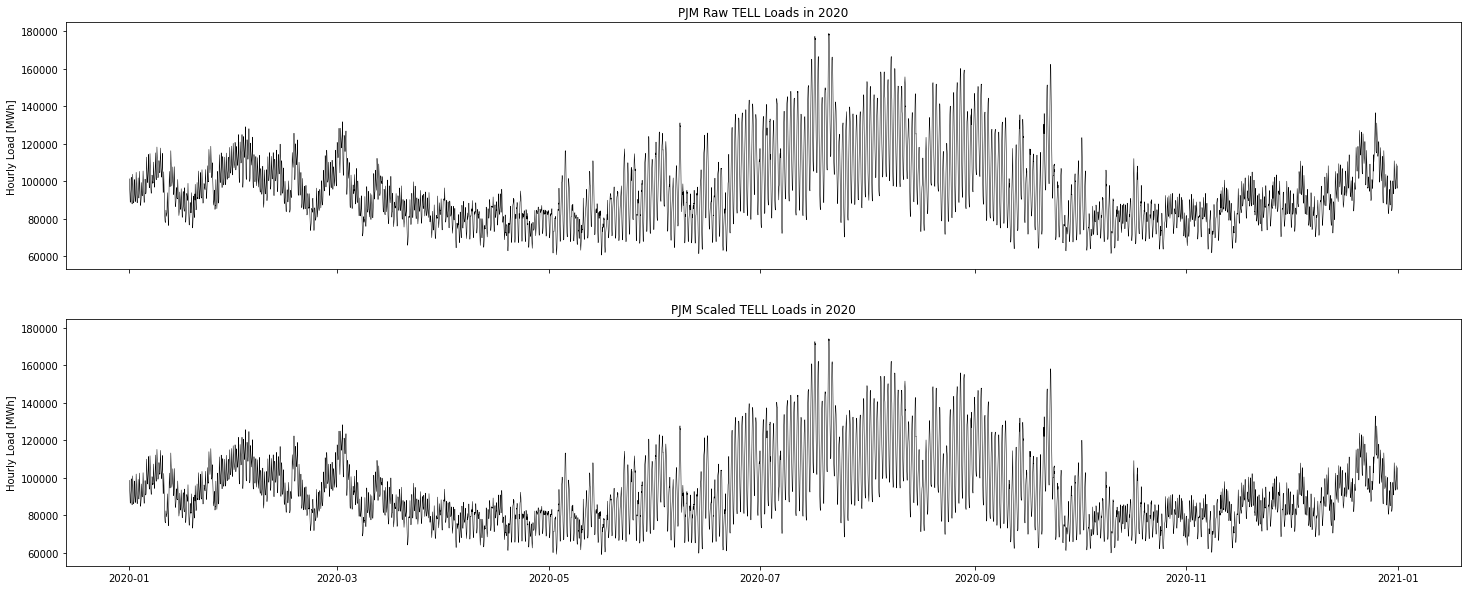

In [6]:
# Plot the time-series of raw and scaled loads from TELL at the BA level for a user-specified BA (e.g., PJM, CISO, ERCO, etc.):
tell.plot_ba_load_time_series(ba_to_plot = 'PJM', 
                              year_to_plot = '2020',
                              data_input_dir = tell_data_dir,
                              image_output_dir = tell_image_dir,
                              image_resolution = 150,
                              save_images = True)
